In [1]:
# To further our exploratory analysis, we developed several predictive machine learning models to forecast CO2 emissions.

In [2]:
# We began with the nationally aggregated monthly CO2 emissions data. We engineered several features due to the recognition of the dynamics present in the data. There were strong seasonal fluctuations, so we engineered variables for month and year. Then, we created twelve lagged variables, representing the CO2 emissions for each of the twelve months in the year .

In [3]:
# The data was then split with 80% of the time designated as the training set and the remaining 20% as the test set. The feature set was standardized using StandardScaler for a mean of 0 and standard deviation of 1 for linear regression and LSTM due to their sensitivity to feature scaling.

In [4]:
# We implemented three different models to compare their results and find the most accurate model given the data: Linear Regression, Random Forest Regressor, and Long Short-Term Memory Network or LSTM. LSTM is a type of recurrent neural network that specializes in time series forecasting. Our model architecture includes 100 hidden units with an output layer that is trained for 500 epochs.

In [5]:
# Model performance was evaluated by the Coefficient of Determination (R^2), which measures the proportion of variance explained by the model, and the Root Mean Squared Error (RMSE), which measures the typical level of prediction errors in relevant units (short tons).

In [6]:
## imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# its and did
import statsmodels.api as sm
import statsmodels.formula.api as smf




## load data
emissions_df = pd.read_csv('monthly_co2_emissions.csv', low_memory=False)
facilities_df = pd.read_csv('facilities.csv', low_memory=False)


## combine fuel types -> this overestimates the values
def combine_fuels(fuel_string):
    fuel_string = str(fuel_string).lower()
    if 'coal' in fuel_string:
        return 'Coal'
    if 'natural gas' in fuel_string:
        return 'Natural Gas'
    if 'oil' in fuel_string:
        return 'Oil'
    if 'wood' in fuel_string or 'solid' in fuel_string:
        return 'Biomass/Solid'
    return 'Other'

facilities_df['Fuel Category'] = facilities_df['Primary Fuel Type'].apply(combine_fuels)


## prep and merge
facility_features = facilities_df[['Facility ID', 'Year', 'Fuel Category']].drop_duplicates(subset=['Facility ID', 'Year'])
df = pd.merge(emissions_df, facility_features, on=['Facility ID', 'Year'], how='left')


## cleaning
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))
features_to_clean = ['Gross Load (MWh)', 'CO2 Mass (short tons)', 'Heat Input (mmBtu)']
for col in features_to_clean:
    df[col] = df.groupby(['State', 'Facility ID'])[col].transform(lambda x: x.interpolate(method='linear'))
df['Fuel Category'].ffill(inplace=True)
df.dropna(subset=features_to_clean + ['Fuel Category'], inplace=True)


## split into RGGI and Non RGGI
rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT', 'VA']
df_rggi = df[df['State'].isin(rggi_states)].copy()
df_non_rggi = df[~df['State'].isin(rggi_states)].copy()


## encode the fuel
fuel_dummies = pd.get_dummies(df['Fuel Category'], prefix='fuel')
df = pd.concat([df, fuel_dummies], axis=1)


## aggregate
agg_cols = ['CO2 Mass (short tons)', 'Gross Load (MWh)', 'Heat Input (mmBtu)'] + list(fuel_dummies.columns)
agg = df.groupby('Date')[agg_cols].sum()
agg = agg.asfreq('MS').interpolate(method='time')


## features for LR and RF
target = 'CO2 Mass (short tons)'
agg_with_lags = agg.copy()
agg_with_lags['year'] = agg_with_lags.index.year
agg_with_lags['month'] = agg_with_lags.index.month
for i in range(1, 13):
    agg_with_lags[f'lag_co2_{i}'] = agg_with_lags[target].shift(i)
agg_with_lags.dropna(inplace=True)


## train test split for LR and RF
train_df = agg_with_lags.iloc[:int(len(agg_with_lags) * 0.8)]
test_df = agg_with_lags.iloc[int(len(agg_with_lags) * 0.8):]


results = {}

# Prep
y_train = train_df[target]
X_train = train_df.drop(columns=target)
y_test = test_df[target]
X_test = test_df.drop(columns=target)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)


# Linear Regression
print("\nLinear Regression")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
results['Linear Regression'] = {'R2': r2_score(y_test, y_pred_lr), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr))}


# Random Forest
print("\nRandom Forest")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
results['Random Forest'] = {'R2': r2_score(y_test, y_pred_rf), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf))}


# LSTM
# features without lag variables
print("\nLSTM")
agg_lstm = agg.copy()
agg_lstm['year'] = agg_lstm.index.year
agg_lstm['month'] = agg_lstm.index.month
agg_lstm.dropna(inplace=True)

# split for LSTM
train_df_lstm = agg_lstm.iloc[:int(len(agg_lstm) * 0.8)]
test_df_lstm = agg_lstm.iloc[int(len(agg_lstm) * 0.8):]
y_test_lstm_actual = test_df_lstm[target].values

# scale LSTM data
scaler_lstm = StandardScaler()
train_scaled_lstm = scaler_lstm.fit_transform(train_df_lstm)
test_scaled_lstm = scaler_lstm.transform(test_df_lstm)

# create sequences
look_back = 12
X_train_lstm, y_train_lstm = [], []
for i in range(look_back, len(train_scaled_lstm)):
    X_train_lstm.append(train_scaled_lstm[i-look_back:i, :])
    y_train_lstm.append(train_scaled_lstm[i, 0])

full_scaled_data = np.concatenate((train_scaled_lstm, test_scaled_lstm), axis=0)
X_test_lstm = []
for i in range(len(train_scaled_lstm), len(full_scaled_data)):
    X_test_lstm.append(full_scaled_data[i-look_back:i, :])

X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)
X_test_lstm = np.array(X_test_lstm)

X_train_t_lstm = torch.from_numpy(X_train_lstm).float()
y_train_t_lstm = torch.from_numpy(y_train_lstm).float().unsqueeze(1)
X_test_t_lstm = torch.from_numpy(X_test_lstm).float()

train_dataset = TensorDataset(X_train_t_lstm, y_train_t_lstm)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

# model
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

lstm_model = LSTM_Model(X_train_lstm.shape[2])
criterion_lstm = nn.MSELoss()
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# train
for epoch in range(500):
    for inputs, labels in train_loader:
        outputs = lstm_model(inputs)
        loss = criterion_lstm(outputs, labels)
        optimizer_lstm.zero_grad()
        loss.backward()
        optimizer_lstm.step()

# predict
lstm_model.eval()
with torch.no_grad():
    y_pred_scaled_lstm = lstm_model(X_test_t_lstm).numpy()

# inverse transform
dummy_pred = np.zeros((len(y_pred_scaled_lstm), train_scaled_lstm.shape[1]))
dummy_pred[:, 0] = y_pred_scaled_lstm.ravel()
y_pred_lstm = scaler_lstm.inverse_transform(dummy_pred)[:, 0]
results['LSTM'] = {'R2': r2_score(y_test_lstm_actual, y_pred_lstm), 'RMSE': np.sqrt(mean_squared_error(y_test_lstm_actual, y_pred_lstm))}


# get results
print("\nModel Comparison")
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='R2', ascending=False))

C:\Users\iancu\AppData\Local\Temp\ipykernel_17628\1023488519.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Fuel Category'].ffill(inplace=True)



Linear Regression

Random Forest

LSTM

Model Comparison
                         R2          RMSE
Linear Regression  0.981754  3.335398e+06
Random Forest      0.906139  7.565039e+06
LSTM               0.765607  1.218718e+07


In [7]:
# Based on the results the Linear Regression model achieved the highest R^2 value (0.98) and the lowest RMSE (3.3e+06), indicating a very strong fit for a model. The LSTM had the weakest metrics given the data.

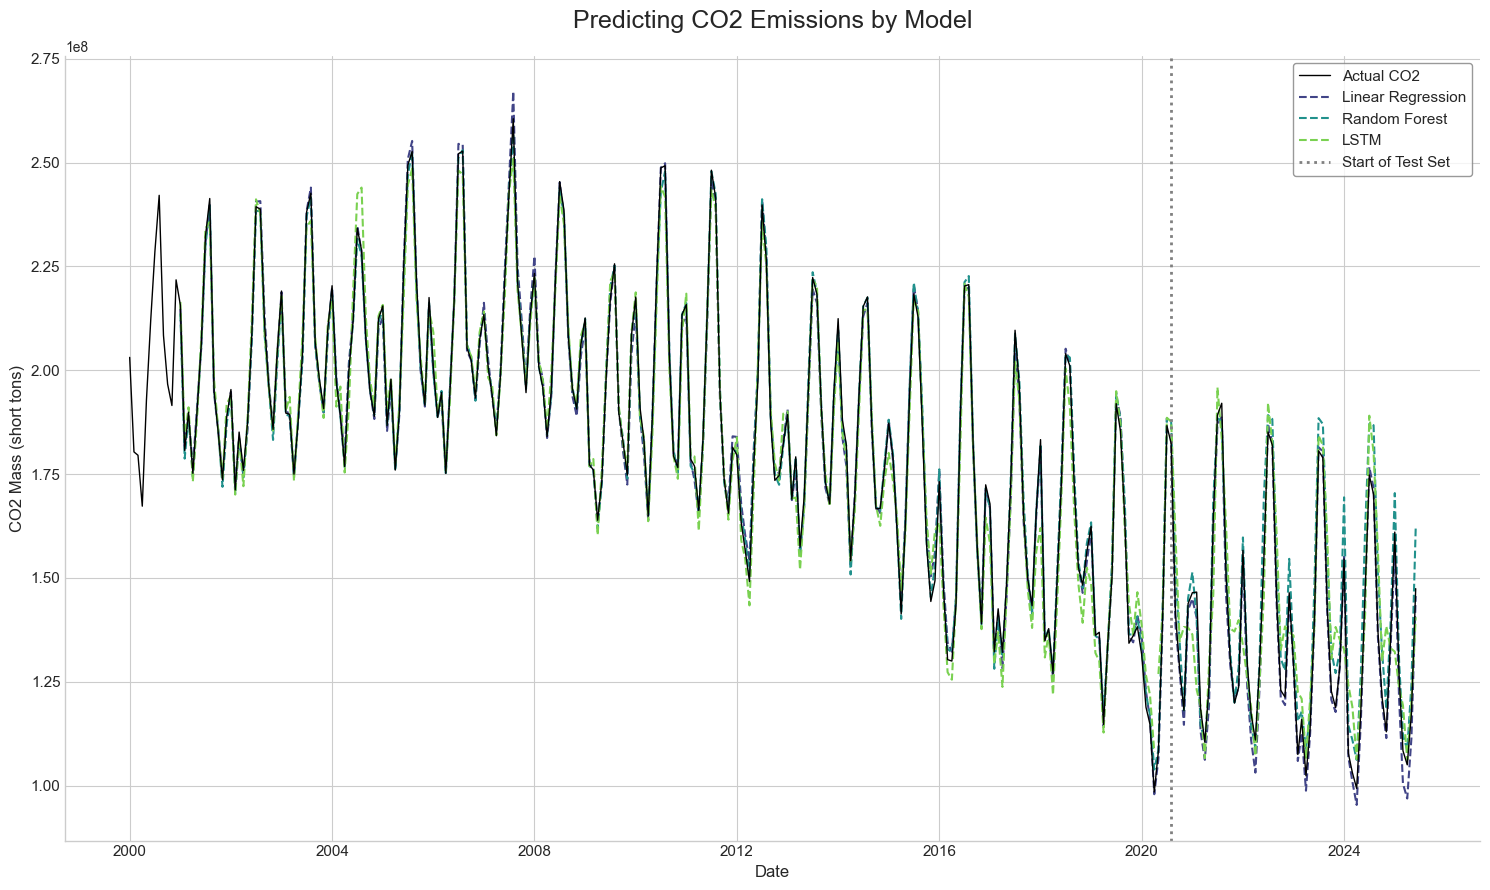

In [8]:
# Get Predictions

# Linear Regression
y_pred_train_lr = lr_model.predict(X_train_scaled)

# Random Forest
y_pred_train_rf = rf_model.predict(X_train)

# LSTM
lstm_model.eval()
with torch.no_grad():
    y_pred_scaled_train_lstm = lstm_model(X_train_t_lstm).numpy()

# inverse transform
dummy_pred_train = np.zeros((len(y_pred_scaled_train_lstm), train_scaled_lstm.shape[1]))
dummy_pred_train[:, 0] = y_pred_scaled_train_lstm.ravel()
y_pred_train_lstm = scaler_lstm.inverse_transform(dummy_pred_train)[:, 0]


# Training
train_pred_lr = pd.Series(y_pred_train_lr, index=y_train.index)
train_pred_rf = pd.Series(y_pred_train_rf, index=y_train.index)
train_pred_lstm = pd.Series(y_pred_train_lstm, index=train_df_lstm.index[look_back:])

# Test
test_pred_lr = pd.Series(y_pred_lr, index=y_test.index)
test_pred_rf = pd.Series(y_pred_rf, index=y_test.index)
test_pred_lstm = pd.Series(y_pred_lstm, index=test_df_lstm.index)


# Plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 9))
colors = cm.viridis(np.linspace(0.2, 0.8, 3))
ax.plot(agg.index, agg[target], label='Actual CO2', color='black', linewidth=1, zorder=10)

# Linear Regression
ax.plot(train_pred_lr.index, train_pred_lr, color=colors[0], linestyle='--')
ax.plot(test_pred_lr.index, test_pred_lr, label='Linear Regression', color=colors[0], linestyle='--')

# Random Forest
ax.plot(train_pred_rf.index, train_pred_rf, color=colors[1], linestyle='--')
ax.plot(test_pred_rf.index, test_pred_rf, label='Random Forest', color=colors[1], linestyle='--')

# LSTM
ax.plot(train_pred_lstm.index, train_pred_lstm, color=colors[2], linestyle='--')
ax.plot(test_pred_lstm.index, test_pred_lstm, label='LSTM', color=colors[2], linestyle='--')

# Format
ax.axvline(y_test.index[0], color='gray', linestyle=':', linewidth=2, label='Start of Test Set')
ax.set_title('Predicting CO2 Emissions by Model', fontsize=18, pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('CO2 Mass (short tons)', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.legend(fontsize=11, frameon=True, facecolor='white', edgecolor='gray')
plt.tight_layout()

plt.show()

In [9]:
# The resulting plot highlights these findings, as the Linear Regression closely tracks the actual historical data while the LSTM model shows it further away from the actual data with higher peaks.

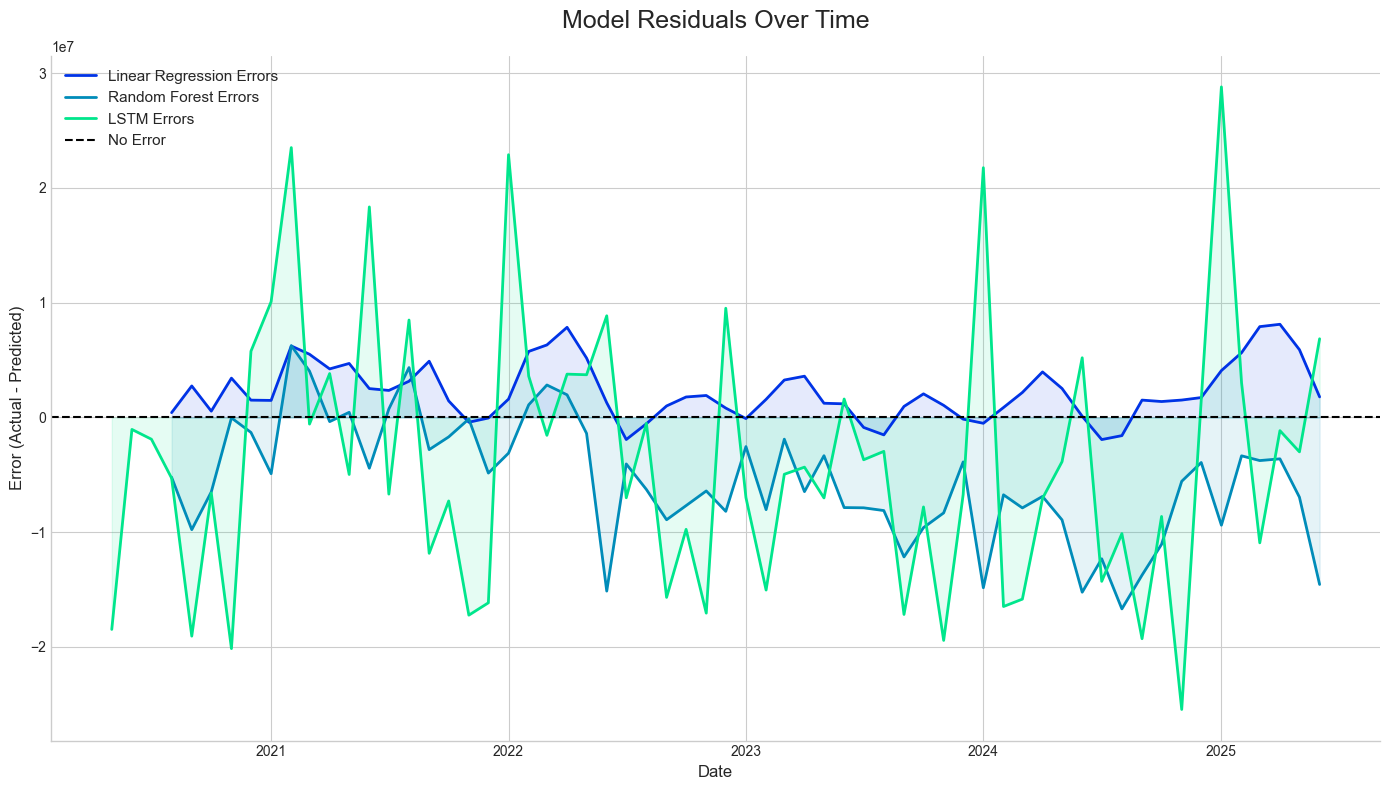

In [10]:
# calculate errors
residuals_lr = y_test - y_pred_lr
residuals_rf = y_test - y_pred_rf
residuals_lstm_values = y_test_lstm_actual - y_pred_lstm
residuals_lstm = pd.Series(residuals_lstm_values, index=test_df_lstm.index)

# plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))
colors = cm.winter(np.linspace(0.2, 0.9, 3))

# model data
models = {
    'Linear Regression': (residuals_lr, colors[0]),
    'Random Forest': (residuals_rf, colors[1]),
    'LSTM': (residuals_lstm, colors[2])
}

# plot residuals
for name, (residuals, color) in models.items():
    ax.plot(residuals.index, residuals, label=f'{name} Errors', color=color, linewidth=2)
    ax.fill_between(residuals.index, residuals, 0, color=color, alpha=0.1)

# format
ax.axhline(0, color='black', linestyle='--', label='No Error', linewidth=1.5)
ax.set_title('Model Residuals Over Time', fontsize=18, pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Error (Actual - Predicted)', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=11)
plt.tight_layout()

plt.show()

In [11]:
# The residuals plot shows the error distribution for each model over the testing dates, showing no overall pattern meaning that all of these models may be a good fit and the assumptions for the model are met.

In [12]:
# We wanted to analyze the key factors linked to CO2 emissions. We created a model using Random Forest to link its feature importance capabilities. This is different to the previous models that used lagged CO2 variables to attribute to time, as this mode will have to use fuel type and power generation metrics to determine emissions.

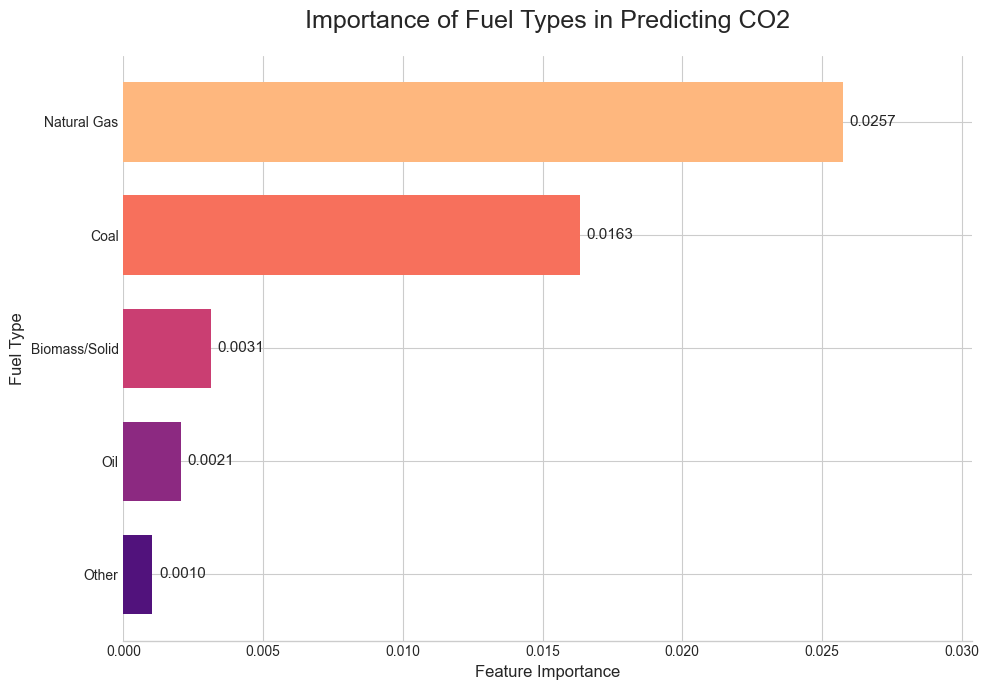

In [13]:


# no lag variables
explanatory_features = [col for col in X_train.columns if 'lag_co2' not in col]

X_train_exp = X_train[explanatory_features]
X_test_exp = X_test[explanatory_features]


# scaler
scaler_exp = StandardScaler()
X_train_exp_scaled = scaler_exp.fit_transform(X_train_exp)
X_test_exp_scaled = scaler_exp.transform(X_test_exp)


# random forest
rf_model_exp = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_exp.fit(X_train_exp, y_train)
rf_importances = pd.Series(rf_model_exp.feature_importances_, index=X_train_exp.columns)


# importance plot
fuel_importance = rf_importances[rf_importances.index.str.startswith('fuel_')]


plt.style.use('seaborn-v0_8-whitegrid')
fuel_importance_sorted = fuel_importance.sort_values()
y_labels = fuel_importance_sorted.index.str.replace('fuel_', '')


fig, ax = plt.subplots(figsize=(10, 7))
colors = cm.magma(np.linspace(0.25, 0.85, len(fuel_importance_sorted)))
bars = ax.barh(y_labels, fuel_importance_sorted.values, color=colors, height=0.7)

# format
ax.set_title('Importance of Fuel Types in Predicting CO2', fontsize=18, pad=20)
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_ylabel('Fuel Type', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', length=0)
ax.set_xlim(right=fuel_importance_sorted.max() * 1.18)
ax.bar_label(bars, fmt='%.4f', padding=5, fontsize=11)
plt.tight_layout()

plt.show()

In [14]:
# We found the use of Natural Gas and Coal as the two most important features for predicting CO2 emissions.

In [15]:
# We want to link these factors to the RGGI region; we trained two separate Random Forest models differing by the included states, where one is exclusively active RGGI participating states and those not.

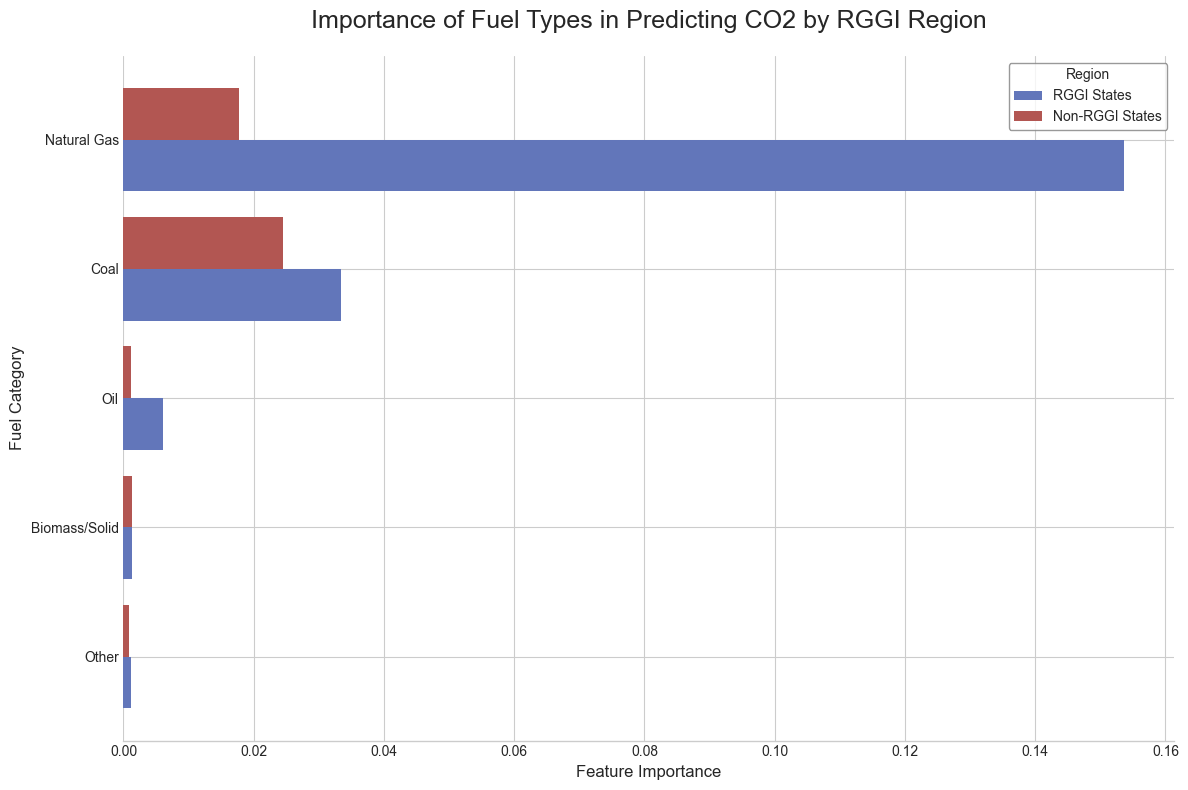

In [16]:
fuel_importances = {}

# loop RGGI and Non RGGI
for name, data in [('RGGI States', df_rggi), ('Non-RGGI States', df_non_rggi)]:
    
    # create dummy
    fuel_dummies = pd.get_dummies(data['Fuel Category'], prefix='fuel')
    data_ml = pd.concat([data, fuel_dummies], axis=1)

    # aggregate data
    agg_cols = ['CO2 Mass (short tons)', 'Gross Load (MWh)', 'Heat Input (mmBtu)'] + list(fuel_dummies.columns)
    agg = data_ml.groupby('Date')[agg_cols].sum().asfreq('MS').interpolate(method='time')
    agg['year'] = agg.index.year
    agg['month'] = agg.index.month
    agg.dropna(inplace=True)

    # features
    target = 'CO2 Mass (short tons)'
    features = [col for col in agg.columns if col != target]
    X = agg[features]
    y = agg[target]

    # train 
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X, y)
    
    # save importants
    importances = pd.Series(model.feature_importances_, index=X.columns)
    fuel_importances[name] = importances[importances.index.str.startswith('fuel_')]

plt.style.use('seaborn-v0_8-whitegrid')
comparison_df = pd.DataFrame(fuel_importances)
comparison_df = comparison_df.sort_values(by='RGGI States', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))
colors = cm.twilight([0.25, 0.75])
comparison_df.plot(kind='barh', ax=ax, color=colors, width=0.8)
ax.set_title('Importance of Fuel Types in Predicting CO2 by RGGI Region', fontsize=18, pad=20)
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_ylabel('Fuel Category', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
clean_labels = [label.get_text().replace('fuel_', '') for label in ax.get_yticklabels()]
ax.set_yticklabels(clean_labels)
ax.legend(title='Region', frameon=True, facecolor='white', edgecolor='gray')
plt.tight_layout()

plt.show()

In [17]:
# In RGGI states, the importance of natural gas is significantly greater, indicating that the fuel type is an indicator for emission levels. In Non-RGGI states, the importance of coal is significantly greater than in RGGI states, due to RGGI initiatives reducing coal generation for the much cleaner burning of natural gases.

In [18]:
# To confirm this switch of fuel type suggested by the feature importance, we generated stacked area charts of CO2 emissions separated by fuel type for both regions

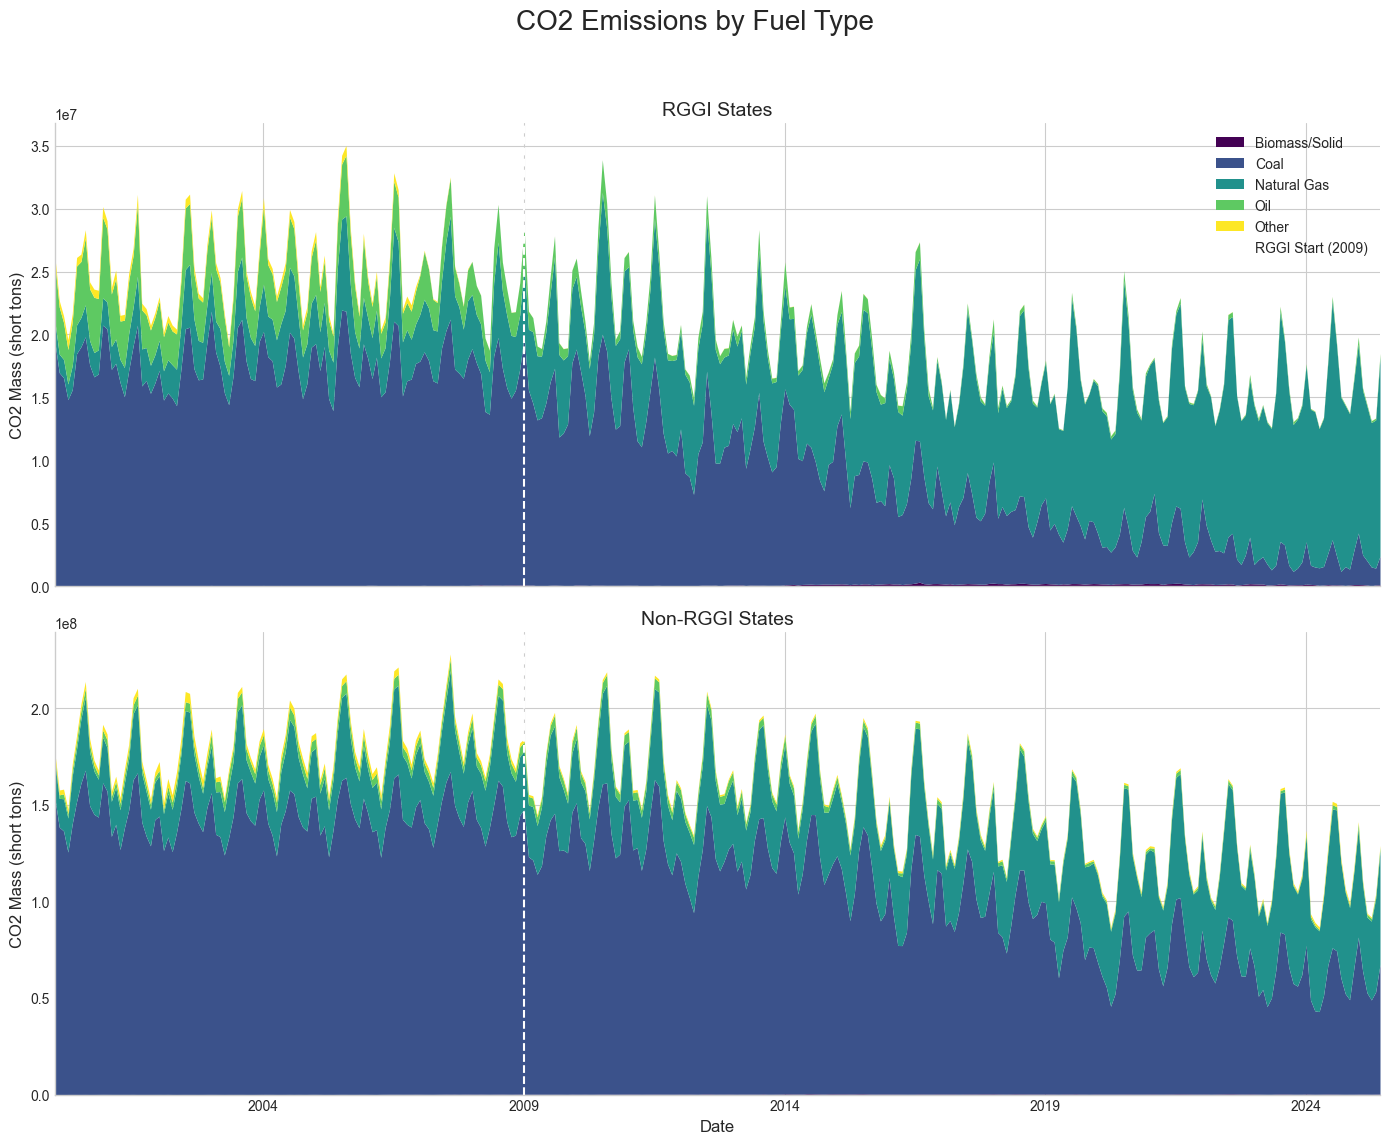

In [19]:
# DF for plot
rggi_ts = df_rggi.groupby(['Date', 'Fuel Category'])['CO2 Mass (short tons)'].sum().unstack().fillna(0)
non_rggi_ts = df_non_rggi.groupby(['Date', 'Fuel Category'])['CO2 Mass (short tons)'].sum().unstack().fillna(0)

# Plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
all_fuels = rggi_ts.columns.union(non_rggi_ts.columns)
colors = cm.viridis(np.linspace(0, 1, len(all_fuels)))
color_map = dict(zip(all_fuels, colors))

# RGGI
rggi_ts.plot(kind='area', stacked=True, ax=axes[0], color=[color_map[c] for c in rggi_ts.columns], lw=0)
axes[0].set_title('RGGI States', fontsize=14)
axes[0].set_ylabel('CO2 Mass (short tons)', fontsize=12)
axes[0].axvline(pd.to_datetime('2009-01-01'), color='white', linestyle='--', label='RGGI Start (2009)')
axes[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Non-RGGI
non_rggi_ts.plot(kind='area', stacked=True, ax=axes[1], color=[color_map[c] for c in non_rggi_ts.columns], lw=0)
axes[1].set_title('Non-RGGI States', fontsize=14)
axes[1].set_ylabel('CO2 Mass (short tons)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].axvline(pd.to_datetime('2009-01-01'), color='white', linestyle='--', label='RGGI Start (2009)')
axes[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Format
fig.suptitle('CO2 Emissions by Fuel Type', fontsize=20)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend().set_visible(False) 
axes[0].legend(handles=handles, labels=labels)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

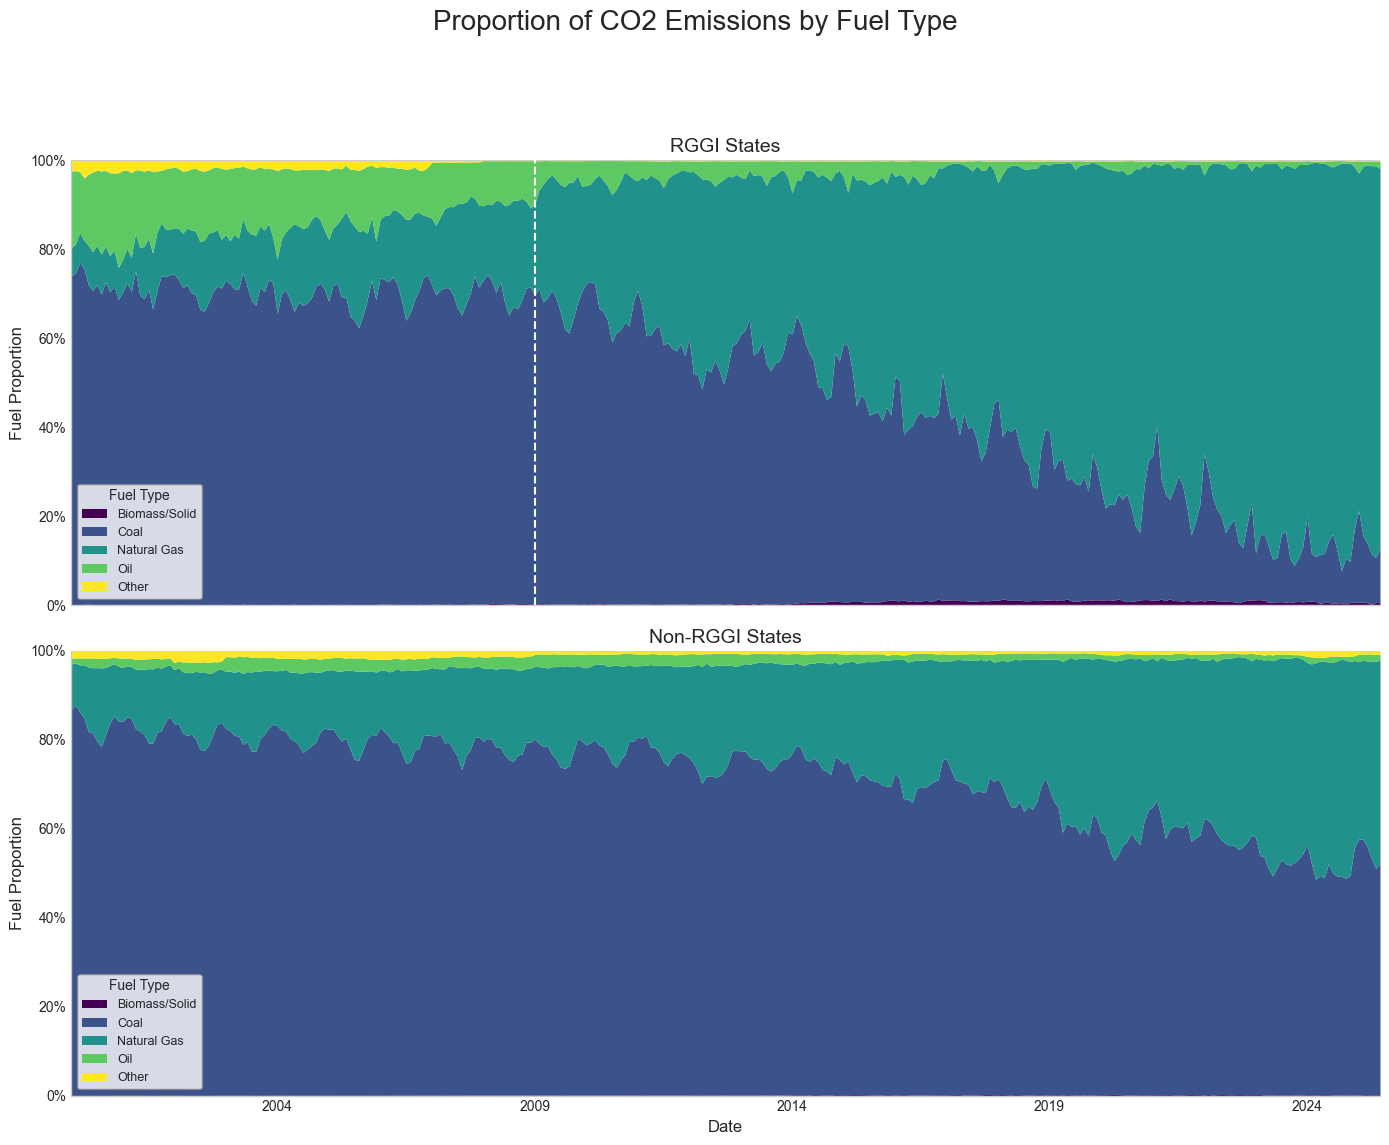

In [20]:
# convert to proportions
rggi_ts_prop = rggi_ts.div(rggi_ts.sum(axis=1), axis=0)
non_rggi_ts_prop = non_rggi_ts.div(non_rggi_ts.sum(axis=1), axis=0)

# plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
all_fuels = rggi_ts_prop.columns.union(non_rggi_ts_prop.columns)
colors = cm.viridis(np.linspace(0, 1, len(all_fuels)))
color_map = dict(zip(all_fuels, colors))

# RGGI
rggi_ts_prop.plot(
    kind='area', stacked=True, ax=axes[0], 
    color=[color_map.get(c) for c in rggi_ts_prop.columns], lw=0
)
axes[0].set_title('RGGI States', fontsize=14)
axes[0].set_ylabel('Fuel Proportion', fontsize=12)
axes[0].axvline(pd.to_datetime('2009-01-01'), color='white', linestyle='--')

# Non-RGGI
non_rggi_ts_prop.plot(
    kind='area', stacked=True, ax=axes[1], 
    color=[color_map.get(c) for c in non_rggi_ts_prop.columns], lw=0
)
axes[1].set_title('Non-RGGI States', fontsize=14)
axes[1].set_ylabel('Fuel Proportion', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)

# format
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylim(0, 1)
fig.suptitle('Proportion of CO2 Emissions by Fuel Type', fontsize=20)
handles, labels = axes[1].get_legend_handles_labels()
for ax in axes:
    ax.legend(handles=handles, labels=labels, loc='lower left', 
              frameon=True, facecolor='white', edgecolor='gray', 
              title='Fuel Type', fontsize=9)
plt.tight_layout(rect=[0, 0.03, 1, 0.92])

plt.show()

In [21]:
# In the RGGI states, a trend away from coal and toward natural gas began around the time of the RGGI policy's implementation in 2009. This trend exists in Non-RGGI states as well, but it is less dramatic.

In [22]:
# Given our analysis so far, we wanted to estimate the actual impact of RGGI on CO2 emissions. For this, we utilized Interrupted Time Series and Difference-in-Differences

In [23]:
# We used an Interrupted Time Series to measure the effect of an ‘intervention’ (RGGI’s policy implementation in 2009) by modeling the level and trend before and after the implementation of RGGI in 2009. This model used aggregated CO2 emissions data solely from the RGGI states. The model is supposed to estimate an immediate change (intervention) and a sustained change over a longer period of time(time_since_intervention).

In [24]:
# prep data
rggi_agg = df_rggi.groupby('Date')['CO2 Mass (short tons)'].sum().asfreq('MS').interpolate(method='time')
rggi_agg = rggi_agg.loc['2000-01-01':'2020-12-01'] # limit date range
rggi_agg = rggi_agg.dropna()

# features
its_df = pd.DataFrame(rggi_agg).reset_index()
its_df.rename(columns={'CO2 Mass (short tons)': 'co2_mass'}, inplace=True)

# time
its_df['time'] = range(len(its_df))

# policy
its_df['intervention'] = (its_df['Date'] >= '2009-01-01').astype(int)

# post policy time
its_df['time_since_intervention'] = 0
intervention_index = its_df[its_df['Date'] >= '2009-01-01'].index[0]
its_df.loc[intervention_index:, 'time_since_intervention'] = range(len(its_df) - intervention_index)

# run model
X = its_df[['time', 'intervention', 'time_since_intervention']]
X = sm.add_constant(X)
y = its_df['co2_mass']
its_model = sm.OLS(y, X).fit()
print("ITS Results")
print(its_model.summary())

ITS Results
                            OLS Regression Results                            
Dep. Variable:               co2_mass   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     71.19
Date:                Sat, 04 Oct 2025   Prob (F-statistic):           3.02e-33
Time:                        18:01:48   Log-Likelihood:                -4160.9
No. Observations:                 252   AIC:                             8330.
Df Residuals:                     248   BIC:                             8344.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const         

In [25]:
# The intervention coefficient is not statistically significant as it the p-value of 0.051 is above the significance level of 0.05. This means the policy did not cause a significant immediate drop in emissions
# The time_since_intervention coefficient is highly significant, as it shows that after 2009, emissions began decreasing by an additional 64,250 tons each month.
# The R-squared of 0.463 means this model explained about 46% of the variation in the RGGI states' emissions.

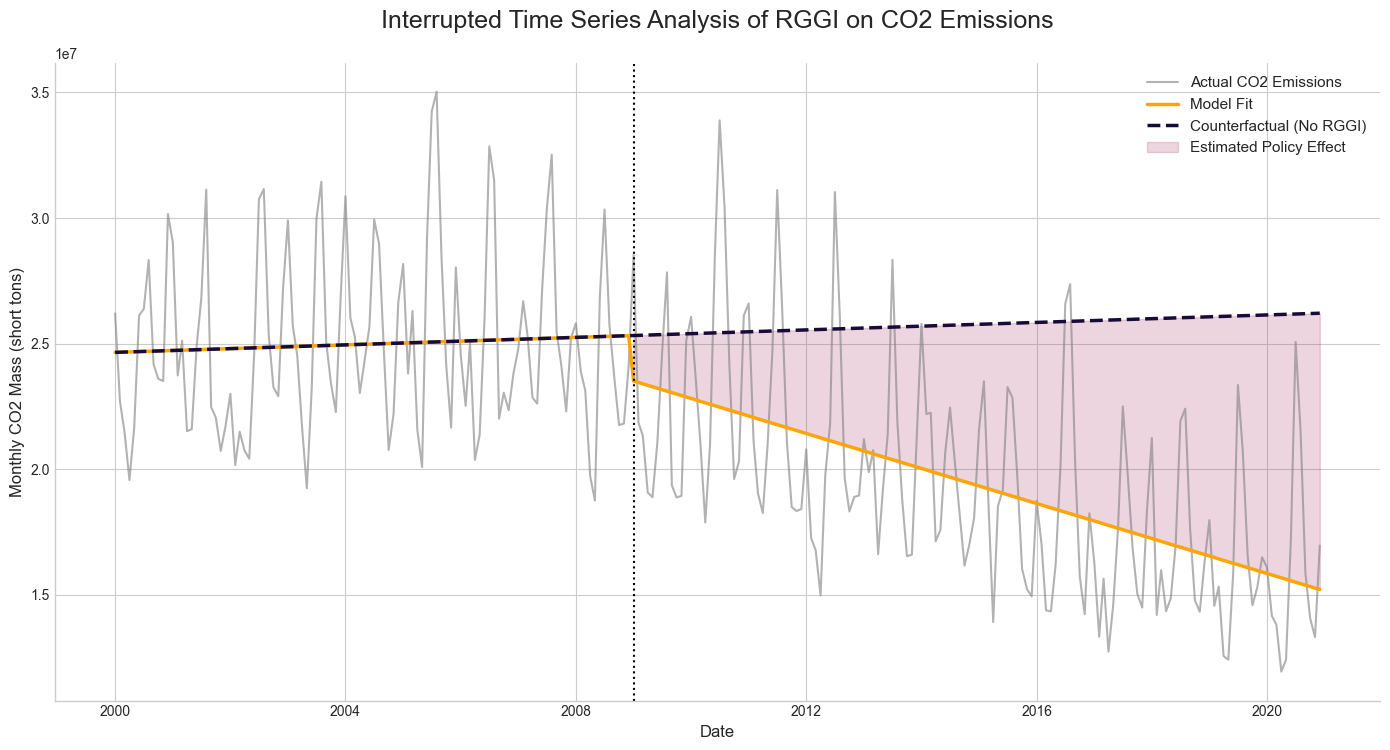

In [26]:
# visualize
its_df['predicted'] = its_model.predict(X)

# counterfactual
X_counterfactual = X.copy()
X_counterfactual['intervention'] = 0
X_counterfactual['time_since_intervention'] = 0
its_df['counterfactual'] = its_model.predict(X_counterfactual)

# plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))
colors = cm.inferno(np.linspace(0.1, 0.8, 3))
ax.plot(its_df['Date'], its_df['co2_mass'], label='Actual CO2 Emissions', color='gray', alpha=0.6, lw=1.5)
ax.plot(its_df['Date'], its_df['predicted'], label='Model Fit', color=colors[2], linestyle='-', lw=2.5)
ax.plot(its_df['Date'], its_df['counterfactual'], label='Counterfactual (No RGGI)', color=colors[0], linestyle='--', lw=2.5)
intervention_date = pd.to_datetime('2009-01-01')

ax.fill_between(
    its_df['Date'], 
    its_df['counterfactual'], 
    its_df['predicted'], 
    where=its_df['Date'] >= intervention_date,
    color=colors[1], 
    alpha=0.2,
    label='Estimated Policy Effect'
)

# format
ax.axvline(intervention_date, color='black', linestyle=':', lw=1.5)
ax.set_title('Interrupted Time Series Analysis of RGGI on CO2 Emissions', fontsize=18, pad=25)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Monthly CO2 Mass (short tons)', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', fontsize=11)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

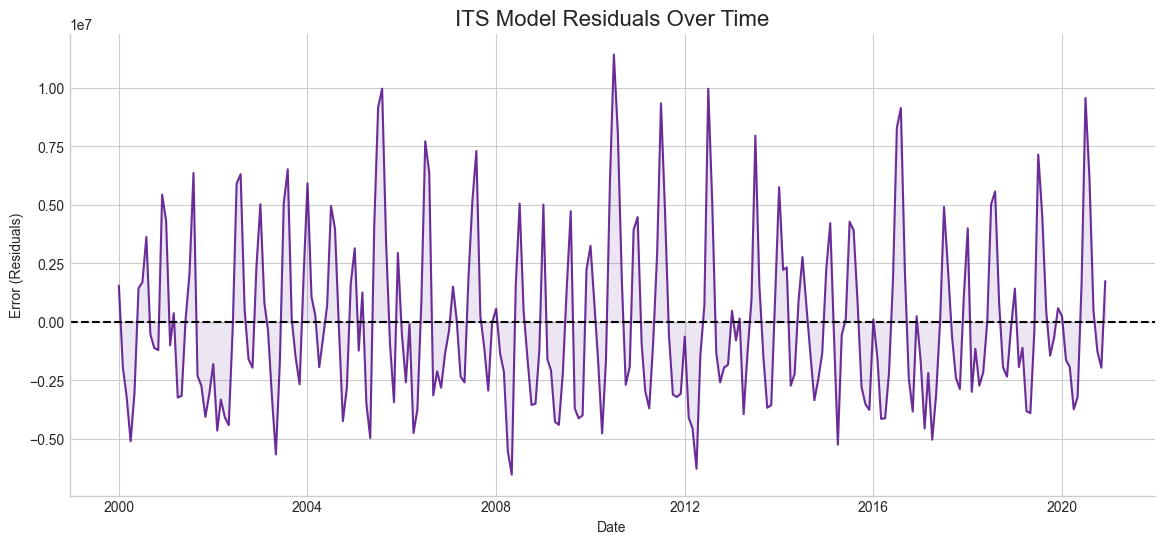

In [27]:
# get residuals
its_df['residuals'] = its_model.resid
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(its_df['Date'], its_df['residuals'], color='indigo', lw=1.5, alpha=0.8)
ax.fill_between(its_df['Date'], its_df['residuals'], 0, color='indigo', alpha=0.1)

# format
ax.axhline(0, color='black', linestyle='--')
ax.set_title('ITS Model Residuals Over Time', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Error (Residuals)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

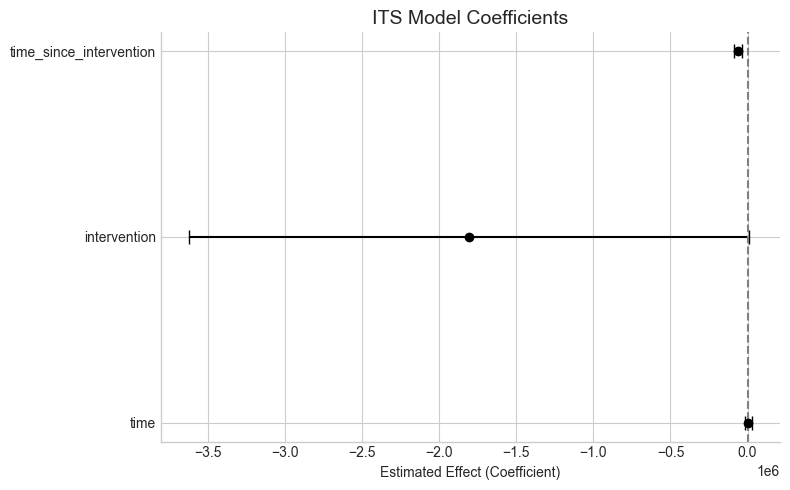

In [28]:
# get results
results_df = pd.DataFrame({
    'coefficient': its_model.params,
    'conf_lower': its_model.conf_int()[0],
    'conf_upper': its_model.conf_int()[1]
}).drop('const')

# plot points
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(results_df['coefficient'], results_df.index, 
            xerr=(results_df['conf_upper'] - results_df['conf_lower']) / 2,
            fmt='o', capsize=5, color='black')


# format
ax.axvline(0, color='gray', linestyle='--')
ax.set_title('ITS Model Coefficients', fontsize=14)
ax.set_xlabel('Estimated Effect (Coefficient)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

plt.show()

In [29]:
# Using a significance level of 0.05, the coefficient plot shows that the intervention term was not statistically significant, meaning RGGI did not cause an immediate, one-time drop in emissions. However, the time_since_intervention coefficient was negative and highly significant (as at a significance level of 0.05, the confidence interval does not include zero). This shows that since the policy’s implementation, there has been a significantly greater rate of decreasing CO2 emissions over time.

In [30]:
# We created a Difference-in-Differences model to improve our ITS model by using a control group of states outside RGGI to account for any overall national trends and external factors that might have occurred around 2009 and onward. The model estimates the effect of RGGI by itself rather than the date of 2009 which may indicate plenty of other factors.

In [31]:
# get group data
rggi_agg = df_rggi.groupby('Date')['CO2 Mass (short tons)'].sum().reset_index()
rggi_agg['group'] = 'RGGI'

non_rggi_agg = df_non_rggi.groupby('Date')['CO2 Mass (short tons)'].sum().reset_index()
non_rggi_agg['group'] = 'Non-RGGI' 

# combine data
did_df = pd.concat([rggi_agg, non_rggi_agg], ignore_index=True)
did_df.rename(columns={'CO2 Mass (short tons)': 'co2_mass'}, inplace=True)

# create features
did_df['post_rggi'] = (did_df['Date'] >= '2009-01-01').astype(int)
did_df['is_rggi'] = (did_df['group'] == 'RGGI').astype(int)

# run the model
did_model = smf.ols('co2_mass ~ is_rggi * post_rggi', data=did_df).fit()

print("\n\nDiD Results")
print(did_model.summary())



DiD Results
                            OLS Regression Results                            
Dep. Variable:               co2_mass   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     2722.
Date:                Sat, 04 Oct 2025   Prob (F-statistic):               0.00
Time:                        18:01:49   Log-Likelihood:                -11125.
No. Observations:                 612   AIC:                         2.226e+04
Df Residuals:                     608   BIC:                         2.228e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.804

In [32]:
# The coefficient is_rggi:post_rggi, is positive and significant, which is associated with how rggi is associated with CO2 emissions after its implementation. This concludes that there was an increase in emissions of 28.4 million tons when compared to non-rggi states
# The R Squared is very high, likely because the is_rggi variable explains the big difference in emissions between the two regions.



DiD Results (Log Transformed)
                            OLS Regression Results                            
Dep. Variable:           log_co2_mass   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     6006.
Date:                Sat, 04 Oct 2025   Prob (F-statistic):               0.00
Time:                        18:01:49   Log-Likelihood:                 152.41
No. Observations:                 612   AIC:                            -296.8
Df Residuals:                     608   BIC:                            -279.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Interc

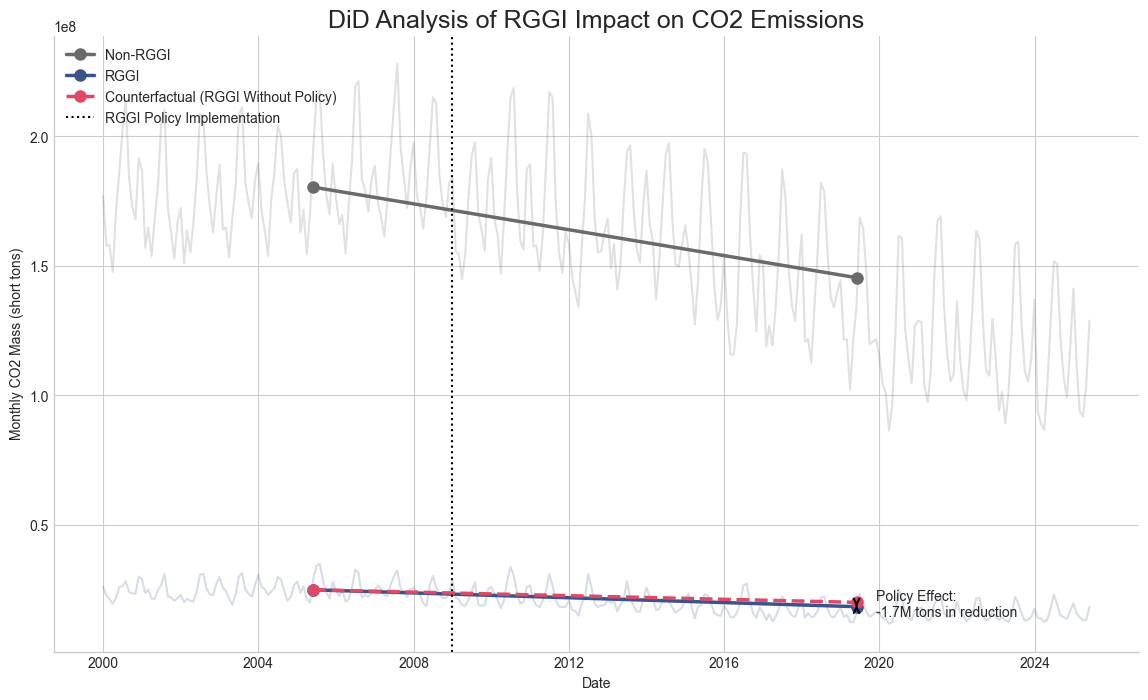

In [33]:
## Corrected DiD Analysis

# get group data
rggi_agg = df_rggi.groupby('Date')['CO2 Mass (short tons)'].sum().reset_index()
rggi_agg['group'] = 'RGGI'

non_rggi_agg = df_non_rggi.groupby('Date')['CO2 Mass (short tons)'].sum().reset_index()
non_rggi_agg['group'] = 'Non-RGGI' 

# combine data
did_df = pd.concat([rggi_agg, non_rggi_agg], ignore_index=True)
did_df.rename(columns={'CO2 Mass (short tons)': 'co2_mass'}, inplace=True)

# create features
did_df['post_rggi'] = (did_df['Date'] >= '2009-01-01').astype(int)
did_df['is_rggi'] = (did_df['group'] == 'RGGI').astype(int)

# normalize using natural log
did_df['log_co2_mass'] = np.log(did_df['co2_mass'])

# model
did_model_log = smf.ols('log_co2_mass ~ is_rggi * post_rggi', data=did_df).fit()
print("\n\nDiD Results (Log Transformed)")
print(did_model_log.summary())

#Counterfactual
summary_stats = did_df.groupby(['group', 'post_rggi'])['co2_mass'].mean().unstack()
summary_stats.columns = ['Before', 'After']
print("\n Average Emissions")
print(summary_stats)

# plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))
colors = {'RGGI': '#3b528b', 'Non-RGGI': '#6a6a6a', 'Counterfactual': '#de4968'}

# plot raw data lightly
ax.plot(did_df[did_df['group']=='RGGI']['Date'], did_df[did_df['group']=='RGGI']['co2_mass'], color=colors['RGGI'], alpha=0.2)
ax.plot(did_df[did_df['group']=='Non-RGGI']['Date'], did_df[did_df['group']=='Non-RGGI']['co2_mass'], color=colors['Non-RGGI'], alpha=0.2)

# get average trend lines
non_rggi_before, non_rggi_after = summary_stats.loc['Non-RGGI']
rggi_before, rggi_after = summary_stats.loc['RGGI']

pre_date = pd.to_datetime('2005-06-01') 
post_date = pd.to_datetime('2019-06-01')

ax.plot([pre_date, post_date], [non_rggi_before, non_rggi_after], 'o-', color=colors['Non-RGGI'], lw=2.5, markersize=8, label='Non-RGGI')
ax.plot([pre_date, post_date], [rggi_before, rggi_after], 'o-', color=colors['RGGI'], lw=2.5, markersize=8, label='RGGI')

# calculate counterfactual
non_rggi_rate_of_change = non_rggi_after / non_rggi_before
counterfactual_after = rggi_before * non_rggi_rate_of_change
ax.plot([pre_date, post_date], [rggi_before, counterfactual_after], 'o--', color=colors['Counterfactual'], lw=2.5, markersize=8, label='Counterfactual (RGGI Without Policy)')

# formatting
ax.axvline(pd.to_datetime('2009-01-01'), color='black', linestyle=':', label='RGGI Policy Implementation')
ax.set_title('DiD Analysis of RGGI Impact on CO2 Emissions', fontsize=18)
ax.set_ylabel('Monthly CO2 Mass (short tons)')
ax.set_xlabel('Date')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.legend(loc='upper left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# show effect
y1 = rggi_after
y2 = counterfactual_after
ax.annotate('', xy=(post_date, y1), xycoords='data',
    xytext=(post_date, y2), textcoords='data',
    arrowprops={'arrowstyle': '<->', 'color': 'black', 'lw': 1.5}, va='center')
ax.text(post_date + pd.DateOffset(months=6), (y1 + y2) / 2, 
        f"Policy Effect:\n{((y1-y2)/1e6):.1f}M tons in reduction", va='center')

plt.show()


In [34]:
# We normalized using natural log to procure proporational change. The results show that if RGGI policy was not in effect, then there would be an additional 1.7M tons of CO2 mass in RGGI states. This analysis shows that due to the intervention of the date of implemention for RGGI, there was a 1.7M ton reduction in CO2 emissions.